<a href="https://colab.research.google.com/github/IvanSalinas2000/Preprocesamiento-y-clasificacion-de-datos/blob/main/Tarea%205/Tarea_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:

# Cargar el dataset CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Etiquetas de CIFAR-10
label_names = {0: "avión", 1: "automóvil", 2: "pájaro", 3: "gato", 4: "ciervo",
               5: "perro", 6: "rana", 7: "caballo", 8: "barco", 9: "camión"}

# Clases que queremos: gato (3), perro (5), caballo (7)
selected_classes = [3, 5, 7]


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


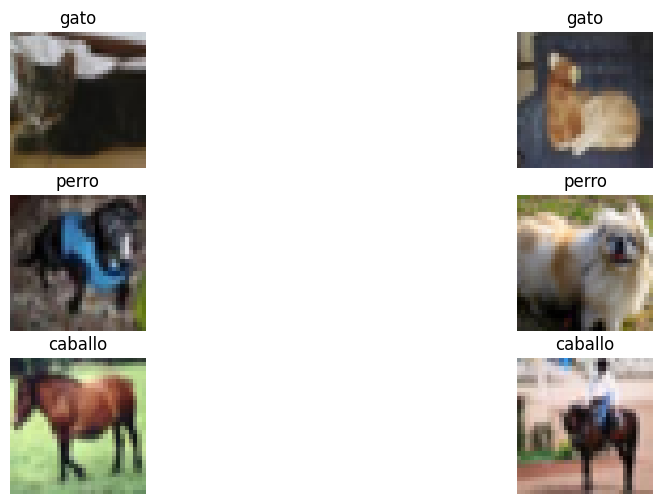

In [3]:

# Filtrar solo las imágenes de las clases seleccionadas
train_mask = np.isin(y_train, selected_classes).flatten()
test_mask = np.isin(y_test, selected_classes).flatten()

x_train, y_train = x_train[train_mask], y_train[train_mask]
x_test, y_test = x_test[test_mask], y_test[test_mask]

# Mostrar las primeras dos imágenes de cada clase
def mostrar_primeras_imagenes(x_train, y_train, selected_classes, label_names):
    plt.figure(figsize=(12, 6))
    for i, clase in enumerate(selected_classes):
        indices_clase = np.where(y_train == clase)[0][:2]
        for j, idx in enumerate(indices_clase):
            plt.subplot(3, 2, i*2 + j + 1)
            plt.imshow(x_train[idx])
            plt.title(label_names[clase])
            plt.axis('off')
    plt.show()

mostrar_primeras_imagenes(x_train, y_train, selected_classes, label_names)


# Reducir el número de imágenes para evitar saturar Colab
num_images_per_class = 2000  # Ajusta según la disponibilidad de RAM
filtered_x_train, filtered_y_train = [], []

for cls in selected_classes:
    idx = np.where(y_train == cls)[0][:num_images_per_class]
    filtered_x_train.append(x_train[idx])
    filtered_y_train.append(y_train[idx])

x_train = np.concatenate(filtered_x_train, axis=0)
y_train = np.concatenate(filtered_y_train, axis=0)



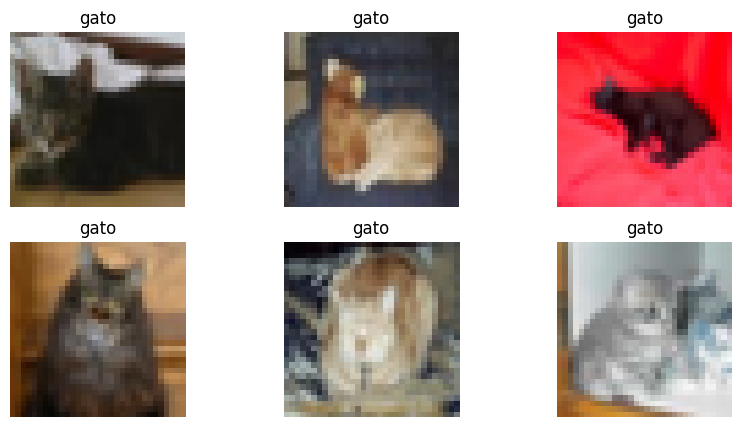

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Normalizar imágenes
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convertir etiquetas a categóricas
label_map = {3: 0, 5: 1, 7: 2}  # Reasignar índices
y_train = np.vectorize(label_map.get)(y_train)
y_test = np.vectorize(label_map.get)(y_test)

y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# Data Augmentation para mejorar generalización
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(x_train)

# Mostrar algunas imágenes preprocesadas
def mostrar_imagenes(x_train, y_train):
    plt.figure(figsize=(10, 5))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(x_train[i])
        plt.title(label_names[selected_classes[np.argmax(y_train[i])]])
        plt.axis('off')
    plt.show()

mostrar_imagenes(x_train, y_train)

# Construcción del modelo CNN optimizado
model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.5),

    Dense(3, activation='softmax')
])


In [5]:
# Compilar modelo
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks para mejorar el rendimiento
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)


In [6]:
# Entrenar el modelo con Data Augmentation
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    validation_data=(x_test, y_test),
                    epochs=20,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 291ms/step - accuracy: 0.4326 - loss: 1.4210 - val_accuracy: 0.3620 - val_loss: 1.2191 - learning_rate: 5.0000e-04
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 262ms/step - accuracy: 0.4926 - loss: 1.1846 - val_accuracy: 0.4133 - val_loss: 1.2644 - learning_rate: 5.0000e-04
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 264ms/step - accuracy: 0.5377 - loss: 1.0553 - val_accuracy: 0.4490 - val_loss: 1.1794 - learning_rate: 5.0000e-04
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 264ms/step - accuracy: 0.5599 - loss: 0.9715 - val_accuracy: 0.5083 - val_loss: 1.0349 - learning_rate: 5.0000e-04
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 41s 268ms/step - accuracy: 0.5699 - loss: 0.9333 - val_accuracy: 0.6060 - val_loss: 0.8604 - learning_rate: 5.0000e-04
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 268ms/step - accuracy: 0.5836 - loss: 0.8948 - val_accuracy: 0.6233 - val_loss: 0.7933 - learning_rate: 5.0000e-04
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 27s 288ms/step - accuracy: 0.58

In [7]:
# Evaluar el modelo
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Pérdida: {loss:.4f}, Precisión: {accuracy:.4f}")



94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7079 - loss: 0.6491
Pérdida: 0.6544, Precisión: 0.7077


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


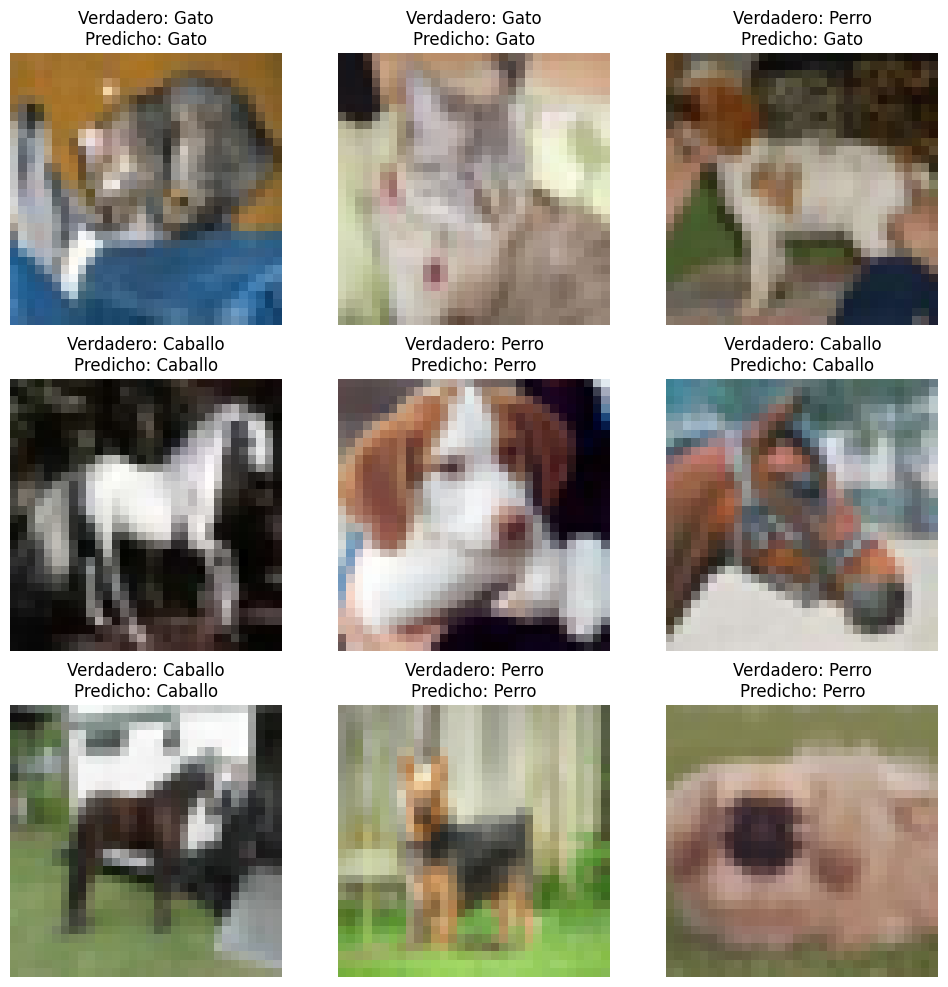

In [8]:
# Visualizar algunas predicciones
def display_predictions(model, x_test, y_test, class_names):
    predictions = model.predict(x_test[:9])
    plt.figure(figsize=(12, 12))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        img = x_test[i]
        true_label = class_names[np.argmax(y_test[i])]
        predicted_label = class_names[np.argmax(predictions[i])]

        plt.imshow(img)
        plt.title(f"Verdadero: {true_label}\nPredicho: {predicted_label}")
        plt.axis('off')
    plt.show()

display_predictions(model, x_test, y_test, ["Gato", "Perro", "Caballo"])


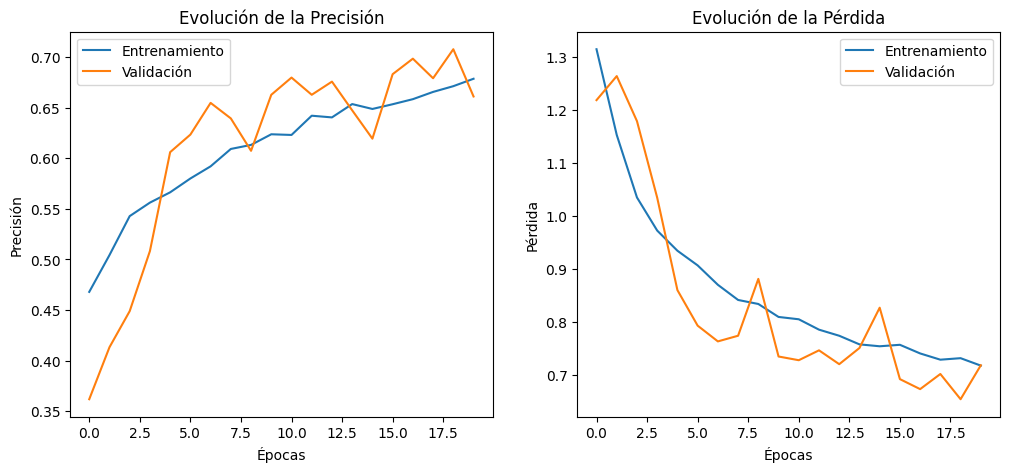

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


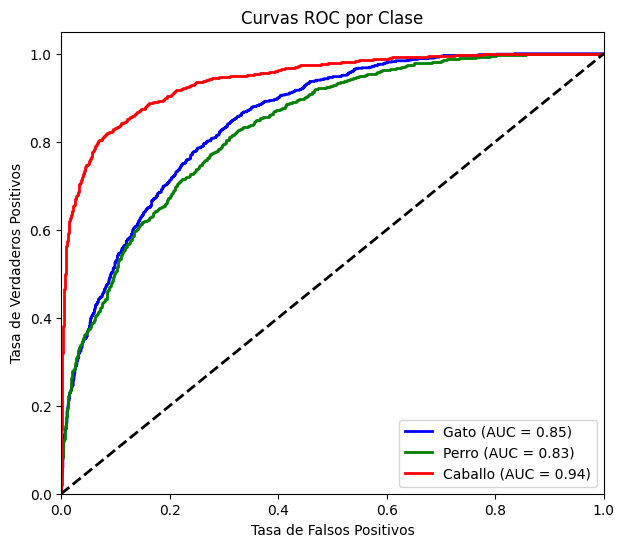

In [9]:

# Graficar accuracy y loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Evolución de la Precisión')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Evolución de la Pérdida')

plt.show()

# Predicciones para curva ROC
y_pred_prob = model.predict(x_test)
y_pred_class = np.argmax(y_pred_prob, axis=1)
y_test_class = np.argmax(y_test, axis=1)

# Calcular curva ROC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar curva ROC
plt.figure(figsize=(7, 6))
for i, color, label in zip(range(3), ['blue', 'green', 'red'], ["Gato", "Perro", "Caballo"]):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()